<a href="https://colab.research.google.com/github/Priyanshu-3103/Cancer-Type-detection/blob/main/Cancer_Type_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)


In [4]:
X = pd.read_csv('/content/drive/MyDrive/Final_Year_Project/Cancer Type Classification using Gene Expression/Dataset/data.csv')
y=pd.read_excel('/content/drive/MyDrive/Final_Year_Project/Cancer Type Classification using Gene Expression/Dataset/labels.xlsx')



In [5]:
print("Gene Expression Shape:", X.shape)
print("Labels Shape:", y.shape)

y.head()


Gene Expression Shape: (801, 20532)
Labels Shape: (801, 2)


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.iloc[:, 1])

print("Cancer Types:", label_encoder.classes_)

Cancer Types: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop('Unnamed: 0', axis=1))

In [16]:
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Reduced Feature Shape:", X_pca.shape)


Reduced Feature Shape: (801, 100)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [18]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, random_state=42)

In [19]:
svm = SVC(
    kernel='rbf',
    C=10,
    probability=True
)

svm.fit(X_train, y_train)


SVC(C=10, probability=True)

In [20]:
rf_prob = rf.predict_proba(X_test)
svm_prob = svm.predict_proba(X_test)

ensemble_prob = (rf_prob + svm_prob) / 2
y_pred = ensemble_prob.argmax(axis=1)


In [21]:
print("Overall Accuracy:",
      accuracy_score(y_test, y_pred))

print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))


Overall Accuracy: 0.9813664596273292
              precision    recall  f1-score   support

        BRCA       0.95      1.00      0.98        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      0.93      0.96        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



In [22]:
cm = confusion_matrix(y_test, y_pred)

cancer_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nCancer-wise Accuracy:")
for i, acc in enumerate(cancer_wise_accuracy):
    print(f"{label_encoder.classes_[i]} : {acc*100:.2f}%")



Cancer-wise Accuracy:
BRCA : 100.00%
COAD : 93.75%
KIRC : 100.00%
LUAD : 92.86%
PRAD : 100.00%


In [26]:
confidence_scores = ensemble_prob.max(axis=1)


In [27]:
threshold = 0.8

high_conf = confidence_scores >= threshold
low_conf = confidence_scores < threshold

print("High-Confidence Accuracy:",
      accuracy_score(y_test[high_conf], y_pred[high_conf]))

print("Low-Confidence Accuracy:",
      accuracy_score(y_test[low_conf], y_pred[low_conf]))


High-Confidence Accuracy: 1.0
Low-Confidence Accuracy: 0.9302325581395349


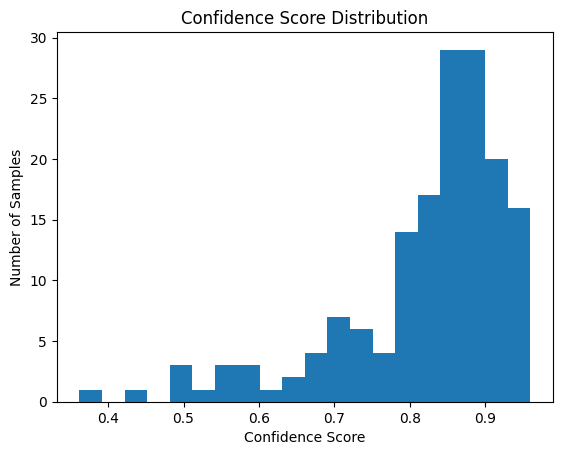

In [28]:
plt.hist(confidence_scores, bins=20)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.title("Confidence Score Distribution")
plt.show()


In [29]:
roc_auc = roc_auc_score(
    y_test,
    ensemble_prob,
    multi_class="ovr"
)

print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.9992891403385311


In [30]:
skf = StratifiedKFold(n_splits=5)
cv_scores = []

for train_idx, test_idx in skf.split(X_pca, y_encoded):
    Xtr, Xte = X_pca[train_idx], X_pca[test_idx]
    ytr, yte = y_encoded[train_idx], y_encoded[test_idx]

    rf.fit(Xtr, ytr)
    preds = rf.predict(Xte)
    cv_scores.append(accuracy_score(yte, preds))

print("Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Accuracy: 0.9787965838509317


In [31]:
decoded_preds = label_encoder.inverse_transform(y_pred)

for i in range(5):
    print(
        "Predicted Cancer:",
        decoded_preds[i],
        "| Confidence:",
        round(confidence_scores[i], 3)
    )


Predicted Cancer: KIRC | Confidence: 0.635
Predicted Cancer: BRCA | Confidence: 0.94
Predicted Cancer: BRCA | Confidence: 0.806
Predicted Cancer: PRAD | Confidence: 0.898
Predicted Cancer: KIRC | Confidence: 0.87
